**Řešíme 2D úlohu konekce:**
$$\begin{align*}
    \frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} &= 0, \quad x \in [0, 2\pi],\,t\in[0, 1] \\
    u(x, 0) &= \sin(x) + \cos(x) \\
    u(0, t) &= u(2\pi, t),
\end{align*}$$
kde $\beta > 0$ je koeficient konvekce. Analytické řešení je
$$\begin{equation*}
    u(x, t) = \sin(x - \beta t) + \cos(x - \beta t).
\end{equation*}$$
Níže natrénujeme model řešící tuto úlohu, a poté jej porovnáme se správným řešením úlohy.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Zakladni importy
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np
import sys

In [10]:
# Import vlastnich modulu
sys.path.append("..")
import src.data.cube_domain as cb
from src.models.mlp_model import MLPModel
from src import train
from src import calculus as calc
from src import utils

In [11]:
# Volba spravneho device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Definice ztratove funkce

BETA = 10 # BETA -- konstanta konvekce

# BETA neni argument funkce, protoze kazdy trenovaci algoritmus ocekava, ze 
# jako argument jen a pouze model a domena.
def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    _, u_x, u_t = calc.compute_derivatives_2d(model, domain.interior)
    pde_loss = torch.mean((u_t + BETA * u_x)**2)

    u_bottom = model(domain.sides[1][0])
    left_loss = torch.mean((u_bottom - torch.sin(domain.sides[1][0][:, 0:1]) 
                            - torch.cos(domain.sides[1][0][:, 0:1]))**2)

    u_left = model(domain.sides[0][0])
    u_right = model(domain.sides[0][1])
    top_bot_loss = torch.mean((u_left - u_right)**2)

    return pde_loss + left_loss + top_bot_loss

def exact_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(x[:, 0:1] - BETA * x[:, 1:2]) + torch.cos(x[:, 0:1] - BETA * x[:, 1:2])

def l2_loss(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    return calc.l2_dist_2d(model, exact_solution, domain.ctx.u_bounds, domain.ctx.l_bounds, device)

In [13]:
# Definice modelu, domeny problemu a optimalizatoru
# prostor x je prvni (nulta) promenna,
# cas t je druha (prvni) promenna
domain_ctx = cb.CubeContext(
    dim=2,
    l_bounds=[0, 0],
    u_bounds=[2*np.pi, 1],
    N_int=1_000,
    N_sides=[(50, 50), (50, 50)],
    device=device,
    mirror_left_right=[True, False]
)

model = MLPModel(2, 1, [40, 40, 40, 40, 40], domain_ctx.u_bounds, domain_ctx.l_bounds).to(device)
domain = cb.CubeDomain(domain_ctx)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer=optimizer, step_size=2_000, gamma=0.1)

In [14]:
# Trenujeme algoritmus a ukladame hodnoty ztraty
context = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=400
)

BETAS = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
loss_values = []

for BETA in BETAS:
    print(f"Current BETA: {BETA}")
    new_vals = train.train_switch_to_lbfgs(context, epochs_with_lbfgs=500, lbfgs_lr=0.1)
    loss_values += new_vals

Current BETA: 0.1
Loss at epoch 1 is: 1.0910271406173706
Loss at epoch 100 is: 0.5477538108825684
Loss at epoch 200 is: 0.0922011286020279
Loss at epoch 300 is: 0.036341592669487
Loss at epoch 400 is: 0.02158057503402233
Switching to LBFGS
Loss at lbfgs-epoch 100 is: 0.00021067626948934048
Loss at lbfgs-epoch 200 is: 0.0002075667434837669
Loss at lbfgs-epoch 300 is: 0.00017102068522945046
Loss at lbfgs-epoch 400 is: 9.598836913937703e-05
Loss at lbfgs-epoch 500 is: 0.00013506202958524227
Current BETA: 1
Loss at epoch 1 is: 0.7784790992736816
Loss at epoch 100 is: 0.01719200424849987
Loss at epoch 200 is: 0.008225585334002972
Loss at epoch 300 is: 0.008408715017139912
Loss at epoch 400 is: 0.004303521476686001
Switching to LBFGS
Loss at lbfgs-epoch 100 is: 5.841773599968292e-05
Loss at lbfgs-epoch 200 is: 4.191214611637406e-05
Loss at lbfgs-epoch 300 is: 2.643795232870616e-05
Loss at lbfgs-epoch 400 is: 3.069653394049965e-05
Loss at lbfgs-epoch 500 is: 2.6248149879393168e-05
Current BET

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


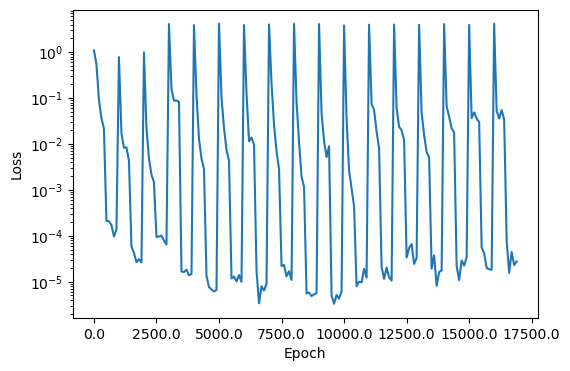

In [15]:
# Vykresleni ztraty
utils.plot_loss_values(loss_values, "Epoch", "Loss")

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


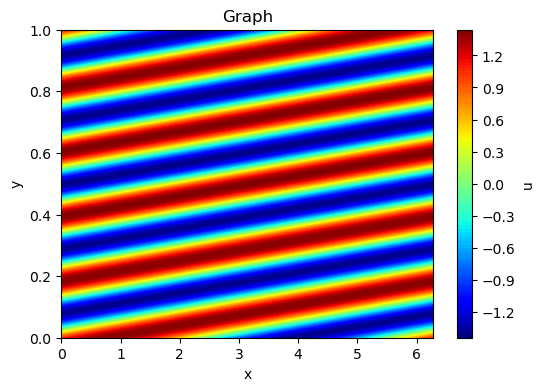

In [16]:
# Vykresleni priblizneho reseni (minus interpolace)
plot_ctx = utils.PlotContext(
    function=model,
    domain=domain,
    patches=[],
)

utils.plot_function_on_2d_cube(model, domain_ctx, plot_ctx)

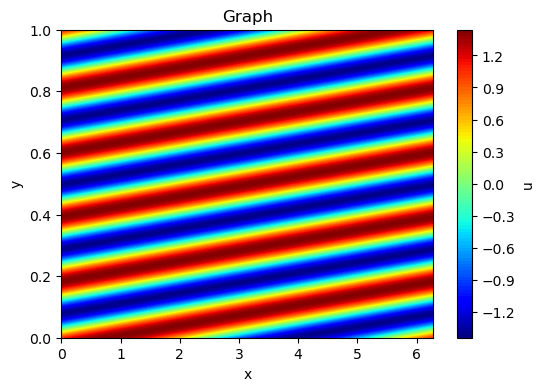

In [17]:
# Vykresleni skutecneho reseni (minus interpolace)
BETA = 30
utils.plot_function_on_2d_cube(exact_solution, domain_ctx, plot_ctx)

In [19]:
# a na zaver porovnani pomoci L2 normy
norm = calc.l2_dist_2d(model, exact_solution, domain_ctx.u_bounds, domain_ctx.l_bounds, device)

print(f"L2 chyba tedy je {norm}")

L2 chyba tedy je 0.0037091600243002176


In [1]:
domain.select_worst(100, model, loss_fn)

NameError: name 'domain' is not defined